# Gaussian Integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

## Solution

In order to solve the integral by Monte Carlo Integration, it must be expressed as: 
$$\int f(x) p(x) dx$$
where $p(x)$ must fulfill the condition: 
$$\int p(x) = 1 $$ 


The distribution at which $p(x)$ refers is the Gaussian Distribution: 
$$\int_{-\infty}^{+\infty} \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right) = 1$$

Accounting for the limits of integration:  
$$\int_{-\infty}^{+\infty} \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right) = 2 \int_{0}^{+\infty} \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)$$

Multiplying and dividing the integral for $ 2 \sigma \sqrt{2\pi}$:

$$ \int_0^\infty x^3  \frac{\sigma\sqrt{2\pi}}{2} \frac{2}{\sigma \sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx$$

the integrand can be expressed with: 

$$f(x)= x^3 \frac {\sigma \sqrt{2\pi}}{2}$$
$$p(x) = \frac{2}{\sigma \sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma^2}\right)$$

where $p(x)$ is a Gaussian distribution with $\mu = 0$.

The solution would be given by:

$$\int f(x) p(x) dx \approx \frac{1}{N}\sum_{i=1}^N f(x_i)$$

where $x_i$ are drawn from the distribution $p(x)$.


In [138]:
import numpy as np
from scipy.stats import norm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [139]:
# Gaussian Distribution from -inf to inf)
mu = 0
sigma = 3 #arbitrary
expected = 2*sigma**4
p = norm(loc = mu, scale = sigma) 

def MCIntegration(N):
    #N Drawn of x_i
    #Drawn from Half Gaussian (from 0 to inf) as it is symmetric
    x = np.abs( p.rvs(size = N))

    #Compute f(x)
    f = 0.5 * x**3 * sigma * (2*np.pi)**0.5

    #Solution of the Integral
    solution = np.mean(f)

    return x,solution

x, computed = MCIntegration(N=1000000)

print(computed)
print(expected)



162.51888869427785
162


### Does the result converge with the number of samples? And how does the error go down?

In [140]:
N=np.logspace(0,7,100, dtype=int) #dtype required, else float
computed = np.array([MCIntegration(n)[1] for n in N])


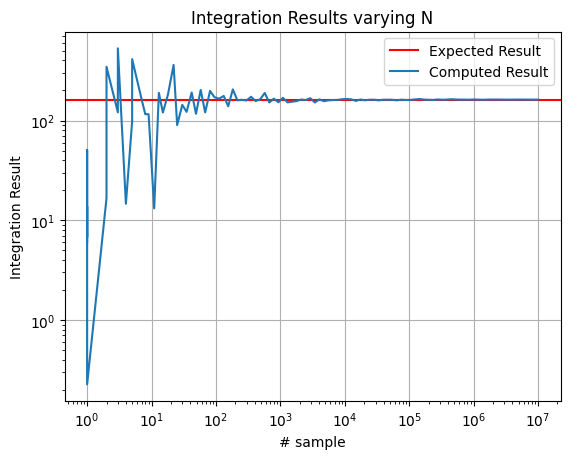

In [141]:
plt.title('Integration Results varying N')
plt.axhline(expected, label = 'Expected Result', color='red')
plt.plot(N, computed, label='Computed Result')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# sample')
plt.ylabel('Integration Result')
plt.grid()
plt.legend()

The integration converges to the expected result increasing the number of samples.

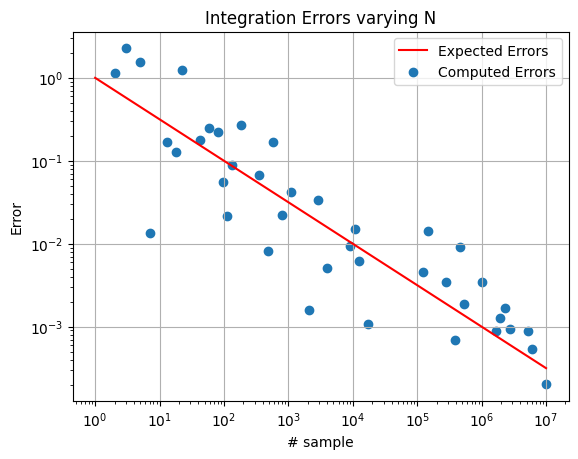

In [142]:
error = (computed - expected)/expected #generally
error_expected = N**(-0.5) #as MLE applied to homoscedastic (known single valued sigma for all data points) : error on mean = sigma/((N)**-1/2)
plt.title('Integration Errors varying N')
plt.plot(N, error_expected, label = 'Expected Errors', color='red')
plt.scatter(N, error, label='Computed Errors')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# sample')
plt.ylabel('Error')
plt.legend()

The error on the result is the error on the mean. Having set an arbitrary sigma that are independent on the extracted values from the distribution, the error is expected to decrease with the number of sample as: 
$$ \sigma_{\mu} = \frac{\sigma}{\sqrt{N}}$$


### For a given $N$, how are the result distributed?

According to the central limit theorem, the distribution given by extracting a sample of N values t times is a Gaussian. 

162.0063088150231
3.5767426499677057


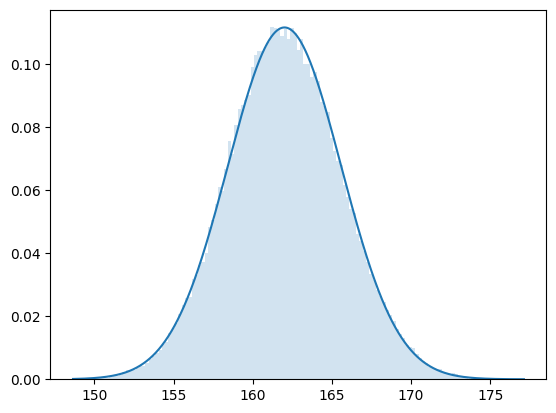

In [143]:
N=10000
times = 100000
results = np.array([MCIntegration(N)[1] for t in range(times)])

mu_ = np.mean(results)
sigma_ = np.std(results)
gauss = norm(loc=mu_, scale=sigma_)
print(mu_)
print(sigma_)


xx = np.linspace(np.min(results), np.max(results), 100000)
plot, =plt.plot(xx, gauss.pdf(xx)) 
plt.hist(results, density=True, bins='fd',alpha=0.2, color = plot.get_color())
plt.show()

In order to compare the extracted distribution with the model of a Gaussian, the KS test is used.
In order to simplify the KS test, I revert the hypothesis and null-hypothesis, thus: 

Hypothesis : The extracted distribution is not Gaussian

Null-Hypothesis : The extracted distribution is Gaussian

By choosing a confidence level of 95%, the threshold of rejection is set at 0.05. If the p-value is higher than the assumed threshold, the null hypothesis cannot be rejected. 


In [144]:
from scipy import stats
_, pvalue = stats.kstest(results, norm(loc=mu_, scale=sigma_).rvs(size = 10000))
print(_, pvalue)

0.011199999999999988 0.20268110705476183


As the p-value is above 0.05, the null-hypothesis is not rejected : the distribution is indeed comparable to a Gaussian.

### How does the distribution change if $N$ increases?

Fixing the t times of sampling, as the size of sample increases (N) the resulting distribution would be a Gaussian (for CLT) 'peaking' around the mean value with lower sigma.

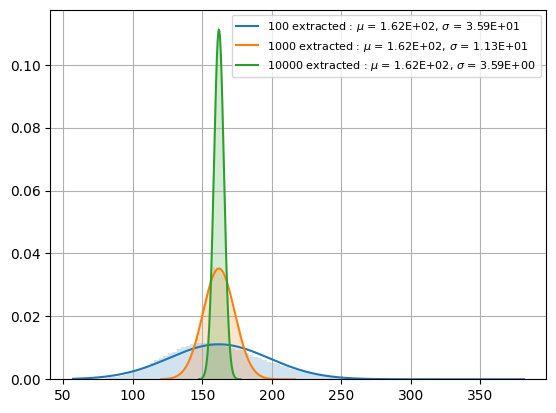

In [145]:
fig, ax = plt.subplots()
N = np.array([1e2, 1e3, 1.e4], dtype=int)
times = 100000
for i in range(len(N)):
    results = np.array([MCIntegration(N[i])[1] for t in range(times)])

    mu_ = np.mean(results)
    sigma_ = np.std(results)
    gauss = norm(loc=mu_, scale=sigma_)

    xx = np.linspace(np.min(results), np.max(results), 100000)
    plot, = ax.plot(xx, gauss.pdf(xx), label = r'{} extracted : $\mu$ = {:.2E}, $\sigma$ = {:.2E} '.format(N[i], mu_, sigma_) )
    ax.hist(results, density=True, bins=100, alpha=0.2, color = plot.get_color()) 
plt.grid()
plt.legend(loc = 'upper right', prop={'size': 8})